# 1. Import datasets

## 1.1 Import libraries and define paths

In [38]:
import os
import json
import tensorflow as tf
import datetime

# AMD Ryzen 7 4800H has 16 logical threads
num_logical_threads = 16 

# Set inter-op and intra-op parallelism to use all logical threads
tf.config.threading.set_inter_op_parallelism_threads(num_logical_threads)
tf.config.threading.set_intra_op_parallelism_threads(num_logical_threads)

# Define the base directory for augmented datasets
BASE_DATASET_PATH = "data/datasets/augmented"

# Dataset types and dataset sources
DATASET_TYPES = ["train", "test", "val"]
DATASET_SOURCES = ["webcam", "seccam", "seccam_2"]

# Function to generate dataset paths dynamically
def get_dataset_paths(dataset_source, dataset_type):
    base_path = os.path.join(BASE_DATASET_PATH, dataset_source, dataset_type)
    return {
        "images": os.path.join(base_path, "images", "*.jpg"),
        "labels": os.path.join(base_path, "labels", "*.json")
    }

checkpoint_filepath = "models/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.keras"

## 1.2 Define image and label loading function

In [39]:
import numpy as np

# Define image sizes for each dataset source
IMAGE_SIZES = {
    "webcam": (480, 640),
    "seccam": (1280, 800),
    "seccam_2": (1280, 800)
}

# Define dataset image shapes
DATASET_SHAPES = {source: (*size, 3) for source, size in IMAGE_SIZES.items()}

def load_image_with_size(image_path, source):
    """
    Reads and decodes an image from a given file path and resizes it based on the source.
    
    Args:
        image_path (tf.Tensor): The file path of the image.
        source (str): The dataset source to determine the target size.
    
    Returns:
        tf.Tensor: A decoded, resized, and normalized image tensor.
    """
    image = tf.io.read_file(image_path)  # Read the image file
    image = tf.image.decode_jpeg(image, channels=3)  # Decode the image (ensure 3 color channels)
    target_size = IMAGE_SIZES[source]
    image = tf.image.resize(image, target_size)  # Resize to the target size
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize pixel values to [0,1]
    return image

def load_labels_with_flag(label_path):
    try:
        if isinstance(label_path, tf.Tensor):
            label_path = label_path.numpy().decode('utf-8')
        with open(label_path, 'r', encoding="utf-8") as f:
            label_data = json.load(f)
        shapes = label_data.get("shapes")
        
        if shapes is not None and isinstance(shapes, list) and len(shapes) > 0:
            # Create a list of labels and points
            labels = []
            points = []
            for shape in shapes:
                labels.append(int(shape["label"]))
                # Convert points to bounding box format [x1, y1, x2, y2]
                pts = np.array(shape["points"], dtype=np.float32)
                x1, y1 = pts.min(axis=0)
                x2, y2 = pts.max(axis=0)
                points.append([x1, y1, x2, y2])
            
            # Convert to numpy arrays and pad to maximum expected objects (assuming max 10 objects)
            max_objects = 10
            num_objects = len(labels)
            
            # Pad labels and points arrays to max_objects
            labels_padded = np.zeros((max_objects,), dtype=np.float32) - 1  # Use -1 for padding
            points_padded = np.zeros((max_objects, 4), dtype=np.float32)
            labels_padded[:num_objects] = labels
            points_padded[:num_objects] = points
            
            # Also return the actual number of objects for masking during training
            return labels_padded, points_padded, True, np.array([num_objects], dtype=np.int32)
        else:
            # Return empty padded arrays when no labels
            max_objects = 10
            return (
                np.zeros((max_objects,), dtype=np.float32) - 1,
                np.zeros((max_objects, 4), dtype=np.float32),
                False,
                np.array([0], dtype=np.int32)
            )
    except Exception as e:
        print(f"Error loading label file {label_path}: {e}")
        max_objects = 10
        return (
            np.zeros((max_objects,), dtype=np.float32) - 1,
            np.zeros((max_objects, 4), dtype=np.float32),
            False,
            np.array([0], dtype=np.int32)
        )

def tf_load_labels(label_path):
    labels, points, valid, num_objects = tf.py_function(
        load_labels_with_flag, 
        [label_path], 
        [tf.float32, tf.float32, tf.bool, tf.int32]
    )
    return labels, points, valid, num_objects

## 1.3 Create dataset pielines for labels

In [40]:
BATCH_SIZE = 8 # Adjust batch size as needed

# Create datasets for each camera source with correct image size
def create_datasets_with_size(dataset_source):
    datasets = {}

    for dataset_type in DATASET_TYPES:
        img_size = IMAGE_SIZES[dataset_source]
        paths = get_dataset_paths(dataset_source, dataset_type)

        # Load image dataset
        images = tf.data.Dataset.list_files(paths["images"], shuffle=False)
        images = images.map(lambda x: load_image_with_size(x, dataset_source), num_parallel_calls=tf.data.AUTOTUNE)

        # Load label dataset
        labels = tf.data.Dataset.list_files(paths["labels"], shuffle=False)
        labels = labels.map(tf_load_labels, num_parallel_calls=tf.data.AUTOTUNE)
        
        # Filter out samples with invalid labels
        labels = labels.filter(lambda labels, points, valid, num_objects: valid)
        
        # Remove the validity flag for downstream processing
        labels = labels.map(lambda labels, points, valid, num_objects: (labels, points, num_objects), 
                          num_parallel_calls=tf.data.AUTOTUNE)

        # Print dataset info
        num_images = len(tf.io.gfile.glob(paths["images"]))
        num_labels = len(tf.io.gfile.glob(paths["labels"]))
        print(f"[{dataset_source}][{dataset_type}] {num_images} images, {num_labels} labels, image size: {img_size}")
        if dataset_type == "train":
            num_images_train = num_images
        
        # Zip images and labels
        dataset = tf.data.Dataset.zip((images, labels))
        dataset = dataset.shuffle(5000 if dataset_type == "train" else 1000).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

        datasets[dataset_type] = dataset

    return datasets, num_images_train

def reshape_and_ensure_shape(images, labels):
    """Reshape and ensure shape for batched data with multiple objects per image."""
    class_labels, coords, num_objects = labels
    
    # No reshape needed for coords as they're already in the right shape (batch, max_objects, 4)
    return (
        tf.ensure_shape(images, [None, None, None, 3]),
        (
            tf.ensure_shape(class_labels, [None, 10]),  # [batch, max_objects]
            tf.ensure_shape(coords, [None, 10, 4]),     # [batch, max_objects, 4]
            tf.ensure_shape(num_objects, [None, 1])     # [batch, 1]
        )
    )

## 1.4 Prepare and combine datasets from all camera sources
We create TensorFlow datasets for each camera source (webcam, seccam, seccam_2), ensuring images are resized to the correct shape for that source. Then, we combine the training, validation, and test splits from all sources into unified datasets. This ensures the model sees a diverse mix of images from all cameras, improving generalization and robustness.

In [41]:
# Create datasets for each camera source with correct image size
webcam_sets, num_images_train = create_datasets_with_size("webcam")
# seccam_sets, num_images_train = create_datasets_with_size("seccam")
# seccam2_sets, num_images_train = create_datasets_with_size("seccam_2")

# Combine train, val, and test splits from all sources for a unified dataset
combined_train = tf.data.Dataset.sample_from_datasets([
    webcam_sets["train"],
    # seccam_sets["train"],
    # seccam2_sets["train"]
])
combined_val = tf.data.Dataset.sample_from_datasets([
    webcam_sets["val"],
    # seccam_sets["val"],
    # seccam2_sets["val"]
])
combined_test = tf.data.Dataset.sample_from_datasets([
    webcam_sets["test"],
    # seccam_sets["test"],
    # seccam2_sets["test"]
])

# Ensure all batches have consistent shapes for model training
# This function reshapes and validates the structure of images and labels
def reshape_and_ensure_shape(images, labels):
    class_labels, coords, num_objects = labels
    
    # No reshape needed for coords as they're already in the right shape (batch, max_objects, 4)
    return (
        tf.ensure_shape(images, [None, None, None, 3]),
        (
            tf.ensure_shape(class_labels, [None, 10]),  # [batch, max_objects]
            tf.ensure_shape(coords, [None, 10, 4]),     # [batch, max_objects, 4]
            tf.ensure_shape(num_objects, [None, 1])     # [batch, 1]
        )
    )

# Apply the shape correction to the combined datasets
train = combined_train.map(reshape_and_ensure_shape).prefetch(tf.data.AUTOTUNE)
val = combined_val.map(reshape_and_ensure_shape).prefetch(tf.data.AUTOTUNE)
test = combined_test.map(reshape_and_ensure_shape).prefetch(tf.data.AUTOTUNE)

[webcam][train] 1260 images, 1260 labels, image size: (480, 640)
[webcam][test] 300 images, 300 labels, image size: (480, 640)
[webcam][val] 240 images, 240 labels, image size: (480, 640)


## 1.5 Check dataset consistency
Check that the shapes of images and labels in a batch are as expected. This helps catch errors early and ensures the model receives data in the correct format.

In [42]:
# Inspect a sample batch from the training dataset to validate the data pipeline
# This helps ensure images and labels are loaded and shaped correctly before training
found_batch = False
for X_batch, y_batch in train.as_numpy_iterator():
    found_batch = True
    print("Batch contents:")
    print("-" * 50)
    print("Image batch shape:", X_batch.shape)
    print("Class label batch shape:", y_batch[0].shape)
    print("Bounding box batch shape:", y_batch[1].shape)
    # Add some basic validations
    assert len(X_batch.shape) == 4, "Images should be 4D (batch, height, width, channels)"
    assert len(y_batch[0].shape) == 2, "Class labels should be 2D (batch, max_objects)"
    assert y_batch[1].shape[1] == 10 and y_batch[1].shape[2] == 4, "Bounding box labels should be 3D (batch, max_objects, 4)"
    # Check that each bounding box has 4 coordinates
    assert y_batch[1].shape[2] == 4, f"Bounding box labels should have 4 coordinates per sample, got shape {y_batch[1].shape}"

    # Optionally, print the first bounding box for the first image in the batch for inspection
    print("First bounding box (first image):", y_batch[1][0, 0])
    
    print("\nValue ranges:")
    print("-" * 50)
    print("Image values range:", X_batch.min(), "to", X_batch.max())
    print("Label values:", np.unique(y_batch[0]))
    print("Bounding box values range:", y_batch[1].min(), "to", y_batch[1].max())
    break  # Only inspect the first batch
if not found_batch:
    print("Dataset is empty or iterator exhausted. Please check if the dataset was properly loaded.")

Batch contents:
--------------------------------------------------
Image batch shape: (8, 480, 640, 3)
Class label batch shape: (8, 10)
Bounding box batch shape: (8, 10, 4)
First bounding box (first image): [ 86.51347 269.36737 428.45203 480.     ]

Value ranges:
--------------------------------------------------
Image values range: 0.0 to 255.0
Label values: [-1.  1.]
Bounding box values range: 0.0 to 640.0


In [43]:
# Debug: Print first 3 label file paths and their parsed contents for one dataset
sample_source = DATASET_SOURCES[0]
sample_type = DATASET_TYPES[0]
paths = get_dataset_paths(sample_source, sample_type)
label_files = tf.io.gfile.glob(paths["labels"])
print("Sample label files:", label_files[:3])
for lf in label_files[:3]:
    try:
        with open(lf, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"{lf}: shapes={{}}".format(data.get('shapes')))
    except Exception as e:
        print(f"{lf}: Error {e}")

Sample label files: ['data\\datasets\\augmented\\webcam\\train\\labels\\f3d9f09a-8335-11ee-9a89-9cfeff47d2fa.0.json', 'data\\datasets\\augmented\\webcam\\train\\labels\\f3d9f09a-8335-11ee-9a89-9cfeff47d2fa.1.json', 'data\\datasets\\augmented\\webcam\\train\\labels\\f3d9f09a-8335-11ee-9a89-9cfeff47d2fa.10.json']
data\datasets\augmented\webcam\train\labels\f3d9f09a-8335-11ee-9a89-9cfeff47d2fa.0.json: shapes=[{'label': '1', 'points': [[123.83868815104167, 225.17203165690105], [424.0856228298611, 444.43127466837564]]}]
data\datasets\augmented\webcam\train\labels\f3d9f09a-8335-11ee-9a89-9cfeff47d2fa.1.json: shapes=[{'label': '1', 'points': [[309.7810438368055, 27.035391998291015], [610.027978515625, 246.2946350097656]]}]
data\datasets\augmented\webcam\train\labels\f3d9f09a-8335-11ee-9a89-9cfeff47d2fa.10.json: shapes=[{'label': '1', 'points': [[87.91437717013892, 31.30205866495768], [388.16131184895846, 250.5613016764323]]}]


## 1.6 Note on image sizes
This notebook supports datasets with different image sizes. Each source's images are resized to a consistent shape before batching, and the model input shape is set to the largest image size among all sources. This ensures compatibility and robust training across all camera types.

# 2. Build Deep Learning using the Functional API

### 2.1 Import Layers and Base Network

In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Activation, Reshape
from tensorflow.keras.applications import EfficientNetB0

### 2.3 Build instance of Network

In [ ]:
N = 10  # Max number of people to recognize

def build_model(input_shape, num_classes=10): 
    """
    Builds a face recognition model that detects and locates multiple faces in an image.
    
    Args:
        input_shape (tuple): Shape of the input images (height, width, channels).
        num_classes (int): Number of classes for classification.
    
    Returns:
        Model: Keras model outputting class probabilities and bounding boxes for multiple objects.
    """

    print(f"Building model with input shape: {input_shape}")
    
    input_layer = Input(shape=input_shape) # Use dynamic input shape
    
    # Load EfficientNetB0 as backbone
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_layer)

    # Freeze initial layers to prevent overfitting
    for layer in base_model.layers[:50]:
        layer.trainable = False

    # Create feature maps at multiple scales
    x = base_model.output
    
    # Object detection head
    features = GlobalAveragePooling2D()(x)
    features = Dense(512, activation='relu')(features)
    features = Dropout(0.5)(features)
    
    # Output heads for multiple objects (max 10 objects)
    max_objects = 10
    
    # Create output heads for each potential object
    # Shape: [batch_size, max_objects, num_classes] for classification
    # Shape: [batch_size, max_objects, 4] for bounding boxes
    
    # Classification Head (Outputs logits, Softmax handled by loss function for stability)
    # This Dense layer outputs a flattened vector (max_objects * num_classes)
    class_logits = Dense(max_objects * num_classes, name='classification_logits')(features)
    # Reshape to (batch_size, max_objects, num_classes)
    classification_output = Reshape((max_objects, num_classes), name='classification_output')(class_logits)
    
    return Model(inputs=input_layer, outputs=[classification_output])

### 2.4 Test out Neural Network

In [46]:
facetracker = build_model(DATASET_SHAPES["webcam"])
facetracker.summary()

Building model with input shape: (480, 640, 3)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 480, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 480, 640,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 480, 640,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 480, 640,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 481, 641,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 240, 320,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 240, 320,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 240, 320,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 240, 320,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 240, 320,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 240, 320,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 240, 320,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 240, 320,  │        512 │ block1a_se_excit

 Total params: 4,777,263 (18.22 MB)

 Trainable params: 4,712,406 (17.98 MB)

 Non-trainable params: 64,857 (253.35 KB)

In [47]:
# Convert the iterator's data to numpy arrays for X and y tensors
X, y = train.as_numpy_iterator().next()

# Print shapes to verify the data structure
print("X shape:", X.shape)
print("y shapes:", [y_item.shape for y_item in y])

X shape: (8, 480, 640, 3)
y shapes: [(8, 10), (8, 10, 4), (8, 1)]


In [48]:
X.shape

(8, 480, 640, 3)

In [49]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [50]:
classes, coords

(array([[[ 0.19218224,  0.09795277,  0.00536218,  0.03428988,
           0.10762605,  0.03527789,  0.20800582, -0.02202217,
           0.13654557,  0.26048127],
         [ 0.25079286, -0.38979447, -0.3339153 ,  0.32132277,
          -0.1849614 , -0.14657006, -0.11257426, -0.01358805,
          -0.48360676,  0.4080438 ],
         [ 0.13510883,  0.19889414, -0.15399002, -0.10230435,
           0.03565665, -0.13759151, -0.37406933, -0.10097531,
           0.3890939 , -0.20673156],
         [-0.19599421,  0.44199035, -0.09469663,  0.10391205,
           0.47969964, -0.0932672 ,  0.27081382, -0.00350389,
          -0.09030618,  0.21068358],
         [ 0.40749377,  0.6030518 ,  0.71156967,  0.04510684,
          -0.00618844,  0.24760625, -0.09445936,  0.02223457,
           0.19496426, -0.3201886 ],
         [ 0.1271413 , -0.24717599,  0.09600314, -0.23994349,
           0.0225265 , -0.46145633,  0.29364038,  0.09643899,
           0.33934486, -0.07405311],
         [-0.10673599, -0.41396722

# 3. Define Losses and Optimizers

### 3.1 Define Optimizer and LR

In [51]:
batches_per_epoch = num_images_train // BATCH_SIZE
if batches_per_epoch == 0:
    raise ValueError("Training dataset is empty. Cannot compute learning rate decay.")

print(f"Number of batches per epoch: {batches_per_epoch}")

# Define a learning rate schedule
# For InverseTimeDecay: lr = initial_learning_rate / (1 + decay_rate * step / decay_steps)
initial_learning_rate = 0.0001
decay_steps = batches_per_epoch # Decay over one epoch
decay_rate_value = (1./0.75) - 1 # Adjust this value to control the decay rate

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate_value,
    staircase=False # Set to True for discrete steps, False for continuous decay
)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)

Number of batches per epoch: 157


### 3.2 Create Localization Loss and Classification Loss

In [ ]:
def classification_loss(y_true, yhat, num_objects):
    """
    Compute classification loss for multiple objects, considering only valid objects.
    
    Args:
        y_true: Ground truth labels, shape [batch, max_objects]
        yhat: Predicted class probabilities, shape [batch, max_objects, num_classes]
        num_objects: Number of actual objects in each image, shape [batch, 1]
    """
    # Create object mask
    object_mask = tf.sequence_mask(tf.squeeze(num_objects), maxlen=tf.shape(y_true)[1])
    object_mask = tf.cast(object_mask, tf.float32)
    
    # Convert ground truth labels to one-hot
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.where(y_true < 0, 0, y_true)  # Replace -1 padding with 0
    y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(yhat)[-1])
    
    # Compute categorical crossentropy
    loss = tf.keras.losses.categorical_crossentropy(
        y_true_one_hot,
        yhat,
        from_logits=True,  # Use logits directly for numerical stability
        label_smoothing=0.1  # Optional: add label smoothing for better generalization
    )
    
    # Apply object mask
    loss = loss * object_mask
    
    # Normalize by number of objects
    num_objects = tf.maximum(tf.cast(num_objects, tf.float32), 1.0)
    return tf.reduce_mean(tf.reduce_sum(loss, axis=1) / num_objects)

# 4. Train Neural Network

## 4.1 Create Custom Model Class

In [ ]:
@tf.keras.utils.register_keras_serializable()
class FaceTracker(Model): 
    def __init__(self, facetracker, **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker
    
    def compile(self, optimizer, loss=None, metrics=None, **kwargs):
        super().compile(optimizer=optimizer, loss=loss, metrics=metrics, **kwargs)

        if loss and isinstance(loss, dict):
            self.closs = loss.get('classification_output')
        else:
            raise ValueError("FaceTracker requires 'loss' to be a dictionary with 'classification_output' key.")

        self.optimizer = optimizer
    
    def train_step(self, batch): 
        X, y = batch
        y_true_class, y_true_boxes, num_objects = y
        
        with tf.GradientTape() as tape: 
            y_pred_class, y_pred_boxes = self.model(X, training=True)
            
            batch_classloss = self.closs(y_true_class, y_pred_class, num_objects)
            
            total_loss = batch_classloss
            
            gradients = tape.gradient(total_loss, self.model.trainable_variables)
        
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        
        self.compiled_metrics.update_state(y_true_class, y_pred_class)
        
        return {
            "total_loss": total_loss, 
            "class_loss": batch_classloss
        }
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        y_true_class, y_true_boxes, num_objects = y
        
        y_pred_class, y_pred_boxes = self.model(X, training=False)
        
        batch_classloss = self.closs(y_true_class, y_pred_class, num_objects)
        
        total_loss = batch_classloss
        
        self.compiled_metrics.update_state(y_true_class, y_pred_class)
        
        return {
            "total_loss": total_loss, 
            "class_loss": batch_classloss,
        }
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)
model.compile(
    optimizer=opt,
    loss={
        'classification_output': classification_loss,
    },
    loss_weights={
        'classification_output': 1.0,
    },
    metrics={
        'classification_output': 'accuracy',
    }
)

## 4.2 Define callbacks

In [55]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

# EarlyStopping Callback
early_stopping_callback = EarlyStopping(
    monitor='val_total_loss',   # Metric to monitor (e.g., validation loss)
    patience=10,                # How many epochs to wait for improvement before stopping
    restore_best_weights=True,  # Restores model weights from the epoch with the best monitored value
    verbose=1                   # Print messages when early stopping is triggered
)

# ModelCheckpoint Callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Set to True to save only weights, False to save entire model
    monitor='val_total_loss', # Monitor the same metric as EarlyStopping
    mode='min',               # 'min' for loss, 'max' for accuracy
    save_best_only=True,      # Save only the best model according to the monitored metric
    verbose=1
)

# TensorBoard Callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) # histogram_freq=1 logs weights/biases distributions every epoch


### 4.3 Train

In [56]:
EPOCHS=2
# Ensure GPU usage
with tf.device('/GPU:0'):
    # Train the model with TensorBoard callback
    hist = model.fit(
        train, 
        steps_per_epoch=batches_per_epoch,
        epochs=EPOCHS, 
        validation_data=val, 
        callbacks=[early_stopping_callback, tensorboard_callback, model_checkpoint_callback], 
        verbose=1, 
        batch_size=BATCH_SIZE
    )
    model.save("models/facetracker.keras")  # Save the entire model after training

Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - class_loss: 1.0740 - regress_loss: 438331.6250 - total_loss: 438332.7188

ValueError: Cannot get result() since the metric has not yet been built.

### 4.4 Plot Performance

In [20]:
hist.history

{'class_loss': [0.03497176989912987,
  0.008347445167601109,
  0.010406090877950191,
  0.010143832303583622,
  0.000573680445086211,
  0.004549944307655096,
  0.00023385636450257152,
  0.0009734598570503294,
  0.0028491634875535965,
  0.00020273594418540597],
 'regress_loss': [664137.8125,
  209020.65625,
  576465.6875,
  143816.375,
  460649.90625,
  216306.5625,
  229057.734375,
  315808.8125,
  732584.4375,
  434255.40625],
 'total_loss': [664137.875,
  209020.671875,
  576465.6875,
  143816.390625,
  460649.90625,
  216306.5625,
  229057.734375,
  315808.8125,
  732584.4375,
  434255.40625],
 'val_class_loss': [0.015245593152940273,
  0.0046482631005346775,
  0.0024809706956148148,
  0.0032567670568823814,
  0.0007880735793150961,
  0.000515047344379127,
  0.0004854630387853831,
  0.0004939815262332559,
  0.00039134989492595196,
  0.0002814366016536951],
 'val_regress_loss': [490650.75,
  471074.375,
  372091.09375,
  349211.625,
  403361.8125,
  399704.90625,
  393661.5625,
  4432

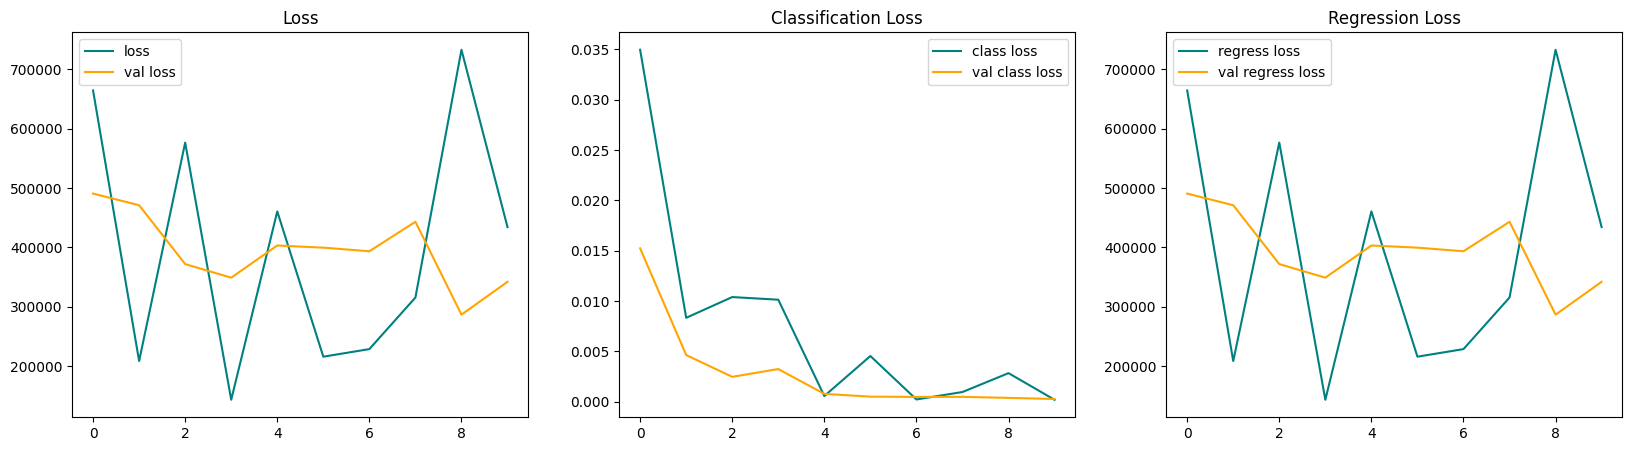

In [33]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 5. Make Predictions

### 5.1 Make Predictions on Test Set

In [22]:
test_data = test.as_numpy_iterator()

In [23]:
test_sample = test_data.next()

In [24]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..247.03125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..252.45605].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.56226].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


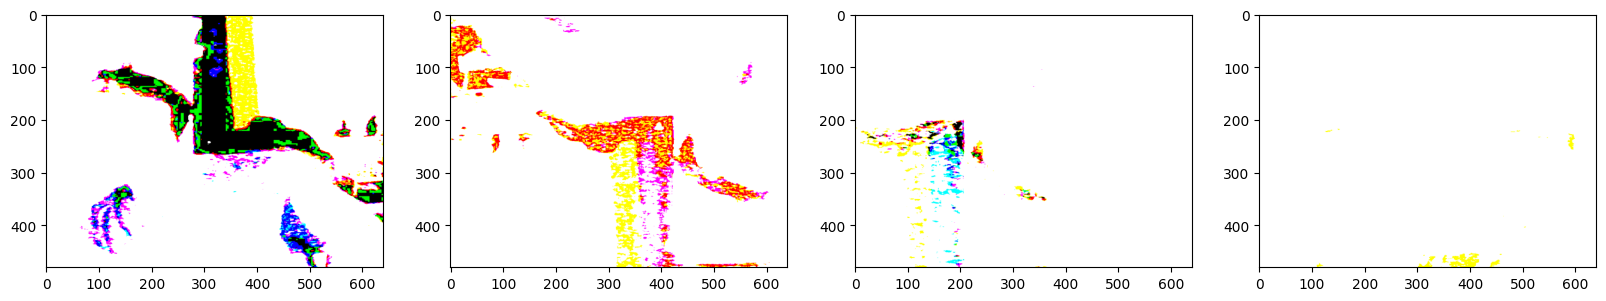

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    # Ensure the sample_image is writable before drawing rectangles
    sample_image = sample_image.copy()

    if np.any(yhat[0][idx] > 0.9):
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# 5.1b Visualize predictions with bounding boxes and class labels
The following cell visualizes predictions by drawing bounding boxes and displaying predicted class labels on sample images from the test set.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


ValueError: operands could not be broadcast together with shapes (2,4) (2,) 

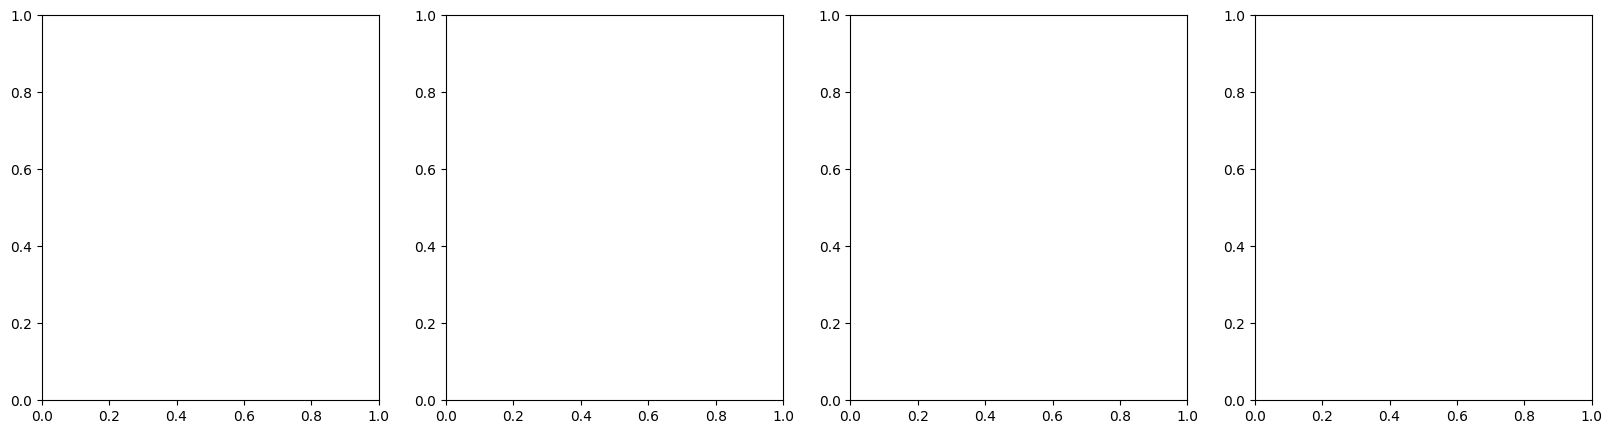

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Get a batch from the test set
X_vis, y_vis = next(iter(test.as_numpy_iterator()))
classes_pred, coords_pred = facetracker.predict(X_vis)

# When visualizing, use the correct image size for bounding box scaling
def get_image_size_from_shape(img):
    return img.shape[0], img.shape[1]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for idx in range(4):
    img = (X_vis[idx] * 255).astype(np.uint8).copy()
    coords = coords_pred[idx]
    class_id = np.argmax(classes_pred[idx]) if classes_pred.ndim > 1 else int(classes_pred[idx])
    conf = np.max(classes_pred[idx]) if classes_pred.ndim > 1 else float(classes_pred[idx])
    h, w = get_image_size_from_shape(img)
    pt1 = tuple(np.multiply(coords[:2], [w, h]).astype(int))
    pt2 = tuple(np.multiply(coords[2:], [w, h]).astype(int))
    cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
# Put class label and confidence
    label = f"Class: {class_id}, Conf: {conf:.2f}"
    cv2.putText(img, label, (pt1[0], max(pt1[1] - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    axes[idx].imshow(img)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

# 5.1c Plot confusion matrix for classification results
This cell computes and plots a confusion matrix for the predicted vs. true class labels on the test set.

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions and true labels for a batch
X_cm, y_cm = next(iter(test.as_numpy_iterator()))
classes_pred, _ = facetracker.predict(X_cm)
true_labels = y_cm[0].flatten().astype(int)
pred_labels = np.argmax(classes_pred, axis=1) if classes_pred.ndim > 1 else classes_pred.astype(int)

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Batch)")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


ValueError: Found input variables with inconsistent numbers of samples: [80, 8]

### 5.2 Save the Model

In [35]:
import keras
model.save('models/facetracker.keras')  # Save the model in Keras format
keras.saving.save_model(facetracker, 'models/custom_model.keras') # Save the model in Keras format with custom objects

d:\Coding\Personal\BP-face-recognition\.venv\Lib\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Get a batch from the test set
X_vis, y_vis = next(iter(test.as_numpy_iterator()))
classes_pred, coords_pred = facetracker.predict(X_vis)

# When visualizing, use the correct image size for bounding box scaling
def get_image_size_from_shape(img):
    return img.shape[0], img.shape[1]

def visualize_predictions(X_vis, y_pred, y_true=None, num_images=4):
    """
    Visualize model predictions for multiple objects in each image.
    
    Args:
        X_vis: Batch of images [batch, height, width, channels]
        y_pred: Tuple of (class_pred, bbox_pred) from model
        y_true: Optional tuple of (class_true, bbox_true, num_objects) for ground truth
        num_images: Number of images to display
    """
    classes_pred, coords_pred = y_pred
    
    fig, axes = plt.subplots(1, num_images, figsize=(5*num_images, 5))
    if num_images == 1:
        axes = [axes]
    
    # Color mapping for different classes
    colors = plt.cm.rainbow(np.linspace(0, 1, N))
    
    for idx in range(min(num_images, len(X_vis))):
        img = (X_vis[idx] * 255).astype(np.uint8).copy()
        h, w = img.shape[:2]
        
        # Draw predicted boxes
        for obj_idx in range(classes_pred.shape[1]):  # Loop through all possible objects
            class_probs = classes_pred[idx, obj_idx]
            coords = coords_pred[idx, obj_idx]
            
            # Skip if no object detected (all class probabilities are very low)
            if np.max(class_probs) < 0.3:
                continue
                
            # Get class with highest probability
            class_id = np.argmax(class_probs)
            conf = class_probs[class_id]
            
            # Convert relative coordinates to absolute
            pt1 = tuple(np.multiply(coords[:2], [w, h]).astype(int))
            pt2 = tuple(np.multiply(coords[2:], [w, h]).astype(int))
            
            # Draw bounding box
            color = (colors[class_id][:3] * 255).astype(int)
            cv2.rectangle(img, pt1, pt2, color, 2)
            
            # Add label
            label = f"Class {class_id}: {conf:.2f}"
            cv2.putText(img, label, (pt1[0], max(pt1[1] - 5, 15)), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Draw ground truth boxes if provided
        if y_true is not None:
            class_true, bbox_true, num_obj = y_true
            n_objects = num_obj[idx][0]
            
            for obj_idx in range(n_objects):
                class_id = int(class_true[idx][obj_idx])
                if class_id < 0:  # Skip padding
                    continue
                    
                coords = bbox_true[idx][obj_idx]
                pt1 = tuple(np.multiply(coords[:2], [w, h]).astype(int))
                pt2 = tuple(np.multiply(coords[2:], [w, h]).astype(int))
                
                # Draw ground truth in dashed lines
                color = (colors[class_id][:3] * 255).astype(int)
                draw_dashed_rectangle(img, pt1, pt2, color)
        
        axes[idx].imshow(img)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

def draw_dashed_rectangle(img, pt1, pt2, color, dash_length=10):
    """Helper function to draw dashed rectangles for ground truth visualization."""
    def draw_dashed_line(img, pt1, pt2, color, dash_length):
        dx = pt2[0] - pt1[0]
        dy = pt2[1] - pt1[1]
        dist = np.sqrt(dx*dx + dy*dy)
        dashes = int(dist/dash_length)
        for i in range(dashes):
            start = np.array([pt1[0] + dx*i/dashes, pt1[1] + dy*i/dashes]).astype(int)
            end = np.array([pt1[0] + dx*(i+0.5)/dashes, pt1[1] + dy*(i+0.5)/dashes]).astype(int)
            cv2.line(img, tuple(start), tuple(end), color, 2)
    
    # Draw four sides
    draw_dashed_line(img, pt1, (pt2[0], pt1[1]), color, dash_length)
    draw_dashed_line(img, (pt2[0], pt1[1]), pt2, color, dash_length)
    draw_dashed_line(img, pt2, (pt1[0], pt2[1]), color, dash_length)
    draw_dashed_line(img, (pt1[0], pt2[1]), pt1, color, dash_length)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
def evaluate_model(model, dataset, iou_threshold=0.5, conf_threshold=0.3):
    """
    Evaluate model performance on a dataset with multiple objects per image.
    """
    metrics = {
        'true_positives': 0,
        'false_positives': 0,
        'false_negatives': 0,
        'class_correct': 0
    }
    
    for batch in dataset:
        images, (gt_classes, gt_boxes, num_objects) = batch
        pred_classes, pred_boxes = model.predict(images)
        
        batch_size = images.shape[0]
        for i in range(batch_size):
            n_objects = num_objects[i][0]
            
            # Get detections for this image
            matched, unmatched_pred, unmatched_gt = match_detections(
                pred_classes[i], pred_boxes[i],
                gt_classes[i], gt_boxes[i],
                n_objects,
                iou_threshold,
                conf_threshold
            )
            
            # Update metrics
            metrics['true_positives'] += len(matched)
            metrics['false_positives'] += len(unmatched_pred)
            metrics['false_negatives'] += len(unmatched_gt)
            
            # Count correct classifications among matched pairs
            for pred_idx, gt_idx, _ in matched:
                pred_class = np.argmax(pred_classes[i, pred_idx])
                if pred_class == gt_classes[i, gt_idx]:
                    metrics['class_correct'] += 1
    
    # Compute final metrics
    total_pred = metrics['true_positives'] + metrics['false_positives']
    total_gt = metrics['true_positives'] + metrics['false_negatives']
    
    metrics['precision'] = metrics['true_positives'] / (total_pred + 1e-6)
    metrics['recall'] = metrics['true_positives'] / (total_gt + 1e-6)
    metrics['f1_score'] = 2 * (metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall'] + 1e-6)
    metrics['class_accuracy'] = metrics['class_correct'] / (metrics['true_positives'] + 1e-6)
    
    return metrics